In [76]:
import numpy as np
from numpy import all, any, array, arctan2, cos, sin, exp, dot, log, logical_and, roll, sqrt, stack, trace, unravel_index, pi, deg2rad, rad2deg, where, zeros, floor, full, nan, isnan, round, float32
from numpy.linalg import det, lstsq, norm
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.feature_extraction.image import extract_patches_2d
from PIL import Image
from functools import cmp_to_key
import cv2
from cv2 import resize, GaussianBlur, subtract, KeyPoint, INTER_LINEAR, INTER_NEAREST
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
import argparse
import math
from math import sqrt
from google.colab.patches import cv2_imshow
import cv2
import pandas as pd
import seaborn as sns
import glob

## Global Variables ##

In [23]:
# Determines the length of floats the SIFT function will tolerate
float_tolerance = 1e-7

# Determines whether to run SIFT in verbose mode
# (Prints out messages for debugging)
VERBOSE_MODE = False

# SIFT Implementation #

Please note: This implementation is largely based on the one originally created by Russ Islam, which can be found here:
https://github.com/rmislam/PythonSIFT

## Image Pyramid Functions ##

In [3]:
# Generate the base image from the given input image
# by upsampling by 2 in both directions and then applying
# a Gaussian blur.
def generateBaseImage(image, sigma, assumed_blur):
    image = resize(image, (0, 0), fx=2, fy=2, interpolation=INTER_LINEAR)
    sigma_diff = sqrt(max((sigma ** 2) - ((2 * assumed_blur) ** 2), 0.01))
    
    # The image blur is now sigma instead of assumed_blur
    return GaussianBlur(image, (0, 0), sigmaX=sigma_diff, sigmaY=sigma_diff)  

# Compute number of octaves in the image pyramid based
# on the original OpenCV implementation.
# (Function of base image shape)
def computeOctaves(img_shape):
    return int(round(log(min(img_shape)) / log(2)-1))

# Generate a list of Gaussian Kernels at which to blur the image
# Default values of sigma, intervals, and octaves are based on section 3
# of David G. Lowe's paper.
def generateGaussianKernels(sigma, intervals):
    # Set number of intervals
    images_per_octave = intervals + 3
    k = 2 ** (1.0 / intervals) # Normalise
    
    # Scale of gaussian blur necessary to go from one blur scale to the next within an octave
    gaussian_kernels = zeros(images_per_octave)
    gaussian_kernels[0] = sigma

    # For each image, work out the appropriate sigma value
    for image_index in range(1, images_per_octave):
        sigma_previous = (k ** (image_index - 1)) * sigma
        sigma_total = k * sigma_previous
        gaussian_kernels[image_index] = sqrt(sigma_total ** 2 - sigma_previous ** 2)
    return gaussian_kernels

# Generate the scale-space pyramid of Gaussian Images
# See: Lecture 7 - Page 14
def generateGaussianImages(img, octaves, kernels):
    
    gaussian_images = []
    
    for octave_index in range(octaves):
        gaussian_images_in_octave = []
        # First image in pyramid already has the correct blur
        gaussian_images_in_octave.append(img)
        
        # Blur each image
        for kernel in kernels[1:]:
            #print(kernel) DEBUG
            #img = gaussian_blur(img, 1, kernel) # ORIGINALLY 0
            img = GaussianBlur(img, (0, 0), sigmaX=kernel, sigmaY=kernel)
            gaussian_images_in_octave.append(img)
        
        # Append images to master array
        gaussian_images.append(gaussian_images_in_octave)
        octave_base = gaussian_images_in_octave[-3]
        
        # Resize image
        img = resize(octave_base, (int(octave_base.shape[1] / 2), int(octave_base.shape[0] / 2)), interpolation=INTER_NEAREST)
    
    return array(gaussian_images, dtype=object)

# Generate a Difference of Gaussian (DoG) image pyramid
def generateDoGImages(gaussian_images):
    
    dog_images = []
    
    # Similar process to latter function
    for gaussian_images_in_octave in gaussian_images:
        dog_images_in_octave = []
        
        for first_image, second_image in zip(gaussian_images_in_octave, gaussian_images_in_octave[1:]):
            # Ordinary subtraction will not work because the images are unsigned integers
            dog_images_in_octave.append(subtract(second_image, first_image))
        
        dog_images.append(dog_images_in_octave)
        
    return array(dog_images, dtype=object)

## Scale Space Extrema Functions ##

In [4]:
# Find the pixel positions of all Scale-Space Extrema in the image pyramid
def findScaleSpaceExtrema(gaussian_images, dog_images, num_intervals, sigma, image_border_width, contrast_threshold=0.04):

    # From OpenCV implementation
    threshold = floor(0.5 * contrast_threshold / num_intervals * 255)  
    keypoints = []

    for octave_index, dog_images_in_octave in enumerate(dog_images):
        for image_index, (first_image, second_image, third_image) in enumerate(zip(dog_images_in_octave, dog_images_in_octave[1:], dog_images_in_octave[2:])):
            # (i, j) is the center of the 3x3 array
            for i in range(image_border_width, first_image.shape[0] - image_border_width):
                for j in range(image_border_width, first_image.shape[1] - image_border_width):
                    # Checks for extrenum values
                    if isPixelAnExtremum(first_image[i-1:i+2, j-1:j+2], second_image[i-1:i+2, j-1:j+2], third_image[i-1:i+2, j-1:j+2], threshold):
                        localization_result = localizeExtremumViaQuadraticFit(i, j, image_index + 1, octave_index, num_intervals, dog_images_in_octave, sigma, contrast_threshold, image_border_width)
                        if localization_result is not None:
                            keypoint, localized_image_index = localization_result
                            keypoints_with_orientations = computeKeypointsWithOrientations(keypoint, octave_index, gaussian_images[octave_index][localized_image_index])
                            for keypoint_with_orientation in keypoints_with_orientations:
                                keypoints.append(keypoint_with_orientation)
    return keypoints

# Returns true if the centre element of the 3x3x3 input array is strictly greater
# than or less than all of its neighbours, and false otherwise
def isPixelAnExtremum(first_subimage, second_subimage, third_subimage, threshold):
  centre_pixel_value = second_subimage[1,1]

  # Checks if pixel value is above the given threshold
  if abs(centre_pixel_value) > threshold:
    if centre_pixel_value > 0:
      # Check pixel against its neighbours
      return all(centre_pixel_value >= first_subimage) and \
                   all(centre_pixel_value >= third_subimage) and \
                   all(centre_pixel_value >= second_subimage[0, :]) and \
                   all(centre_pixel_value >= second_subimage[2, :]) and \
                   centre_pixel_value >= second_subimage[1,0] and \
                   centre_pixel_value >= second_subimage[1,2]
    elif centre_pixel_value < 0:
        return all(centre_pixel_value <= first_subimage) and \
                all(centre_pixel_value <= third_subimage) and \
                all(centre_pixel_value <= second_subimage[0, :]) and \
                all(centre_pixel_value <= second_subimage[2, :]) and \
                centre_pixel_value <= second_subimage[1,0] and \
                centre_pixel_value <= second_subimage[1,2]
  return False

# Iteratively refine pixel positions of Scale Space extrema
# via quadratic fit around each extremum's neighbors
def localizeExtremumViaQuadraticFit(i, j, image_index, octave_index, intervals, dog_images_in_octave, 
                                    sigma, contrast_threshold, image_border_width, 
                                    eigenvalue_ratio=10, attempts_until_convergence=5):
  extremum_is_outside_image = False
  image_shape = dog_images_in_octave[0].shape

  for attempt_index in range(attempts_until_convergence):
    # We need to convert from uint8 to float32 to compute derivatives
    # after which we need to rescale pixel values to [0, 1] to apply Lowe's thresholds
    first_image, second_image, third_image = dog_images_in_octave[image_index-1:image_index+2]
    pixel_cube = stack([first_image[i-1:i+2, j-1:j+2],
                        second_image[i-1:i+2, j-1:j+2],
                        third_image[i-1:i+2, j-1:j+2]]).astype('float32') / 255.
    # Compute the gradient and hessian values
    gradient = computeGradientAtCentrePixel(pixel_cube)
    hessian = computeHessianAtCentrePixel(pixel_cube)

    # Compute the least-squares solution of the hessian and the gradient matrices
    extremum_update = -lstsq(hessian, gradient, rcond=None)[0]
    if abs(extremum_update[0]) < 0.5 and abs(extremum_update[1]) < 0.5 and abs(extremum_update[2]) < 0.5:
        break
    j += int(round(extremum_update[0]))
    i += int(round(extremum_update[1]))
    image_index += int(round(extremum_update[2]))

    # Make sure the new pixel_cube will lie entirely within the image
    if i < image_border_width or i >= image_shape[0] - image_border_width or j < image_border_width or j >= image_shape[1] - image_border_width or image_index < 1 or image_index > intervals:
        extremum_is_outside_image = True
        break

  # Logging functions
  if extremum_is_outside_image:
      #logger.debug('Updated extremum moved outside of image before reaching convergence. Skipping...')
      return None
  if attempt_index >= attempts_until_convergence - 1:
      #logger.debug('Exceeded maximum number of attempts without reaching convergence for this extremum. Skipping...')
      return None

  functionValueAtUpdatedExtremum = pixel_cube[1, 1, 1] + 0.5 * dot(gradient, extremum_update)
  if abs(functionValueAtUpdatedExtremum) * intervals >= contrast_threshold:
      xy_hessian = hessian[:2, :2]
      xy_hessian_trace = trace(xy_hessian)
      xy_hessian_det = det(xy_hessian)
      if xy_hessian_det > 0 and eigenvalue_ratio * (xy_hessian_trace ** 2) < ((eigenvalue_ratio + 1) ** 2) * xy_hessian_det:
          # Contrast check passed -- construct and return OpenCV KeyPoint object
          # MAKE OWN KEYPOINT^^^
          keypoint = KeyPoint()
          keypoint.pt = ((j + extremum_update[0]) * (2 ** octave_index), (i + extremum_update[1]) * (2 ** octave_index))
          keypoint.octave = octave_index + image_index * (2 ** 8) + int(round((extremum_update[2] + 0.5) * 255)) * (2 ** 16)
          # Octave_index + 1 because the input image was doubled
          keypoint.size = sigma * (2 ** ((image_index + extremum_update[2]) / float32(intervals))) * (2 ** (octave_index + 1)) 
          keypoint.response = abs(functionValueAtUpdatedExtremum)
          return keypoint, image_index
  return None

# Approximate the gradient at the centre pixel (of 3x3x3 array)
# by using the "Central Difference" formula (Order: O(h^2))
# See: https://learn.lboro.ac.uk/archive/olmp/olmp_resources/pages/workbooks_1_50_jan2008/Workbook31/31_3_num_diff.pdf
def computeGradientAtCentrePixel(pixel_array):
  # Central Difference formula considering h (step size) of order O(h^2) for f'(x) 
  # is (f(x + h) - f(x - h)) / (2 * h)
  # Since h=1 in this case, we get: f'(x) = (f(x + 1) - f(x - 1)) / 2
  # NOTE: x corresponds to second array axis, y corresponds to first array axis, and s (scale) corresponds to third array axis
  dx = 0.5 * (pixel_array[1, 1, 2] - pixel_array[1, 1, 0])
  dy = 0.5 * (pixel_array[1, 2, 1] - pixel_array[1, 0, 1])
  ds = 0.5 * (pixel_array[2, 1, 1] - pixel_array[0, 1, 1])

  return array([dx, dy, ds])

# Same principles as the function above
def computeHessianAtCentrePixel(pixel_array):
  
  # Central Difference formula considering h (step size) of order O(h^2) for 
  # (d^2) f(x, y) / (dx dy) = (f(x + h, y + h) - f(x + h, y - h) - f(x - h, y + h) + f(x - h, y - h)) / (4 * h ^ 2)
  # Since h=1 in this case, we get: 
  # (d^2) f(x, y) / (dx dy) = (f(x + 1, y + 1) - f(x + 1, y - 1) - f(x - 1, y + 1) + f(x - 1, y - 1)) / 4
  
  centre_pixel_value = pixel_array[1,1,1]

  dxx = pixel_array[1,1,2] - 2 * centre_pixel_value + pixel_array[1,1,0]
  dyy = pixel_array[1,2,1] - 2 * centre_pixel_value + pixel_array[1,0,1]
  dss = pixel_array[2,1,1] - 2 * centre_pixel_value + pixel_array[0,1,1]

  dxy = 0.25 * (pixel_array[1,2,2] - pixel_array[1,2,0] - pixel_array[1,0,2] + pixel_array[1,0,0])
  dxs = 0.25 * (pixel_array[2,1,2] - pixel_array[2,1,0] - pixel_array[0,1,2] + pixel_array[0,1,0])
  dys = 0.25 * (pixel_array[2,2,1] - pixel_array[2,0,1] - pixel_array[0,2,1] + pixel_array[0,0,1])
  return array([[dxx, dxy, dxs], 
              [dxy, dyy, dys],
              [dxs, dys, dss]])

## Keypoint Orientation Function ##

In [5]:
# Computes the orientations of each keypoint
def computeKeypointsWithOrientations(keypoint, octave_index, gaussian_image, radius_factor=3, 
                                     num_bins=36, peak_ratio=0.8, scale_factor=1.5):
  keypoints_with_orientations = []
  image_shape = gaussian_image.shape

  # Comparison with keypoint.size computation in "localizeExtremumViaQuadraticFit()"
  scale = scale_factor * keypoint.size / float32(2 ** (octave_index + 1))

  # Prepare histogram values
  radius = int(round(radius_factor * scale))
  weight_factor = -0.5 / (scale ** 2)
  raw_histogram = zeros(num_bins)
  smooth_histogram = zeros(num_bins)

  # Go through the Y-range
  for i in range(-radius, radius + 1):
        region_y = int(round(keypoint.pt[1] / float32(2 ** octave_index))) + i
        if region_y > 0 and region_y < image_shape[0] - 1:
            # Go through the X-range
            for j in range(-radius, radius + 1):
                region_x = int(round(keypoint.pt[0] / float32(2 ** octave_index))) + j
                if region_x > 0 and region_x < image_shape[1] - 1:
                    dx = gaussian_image[region_y, region_x + 1] - gaussian_image[region_y, region_x - 1]
                    dy = gaussian_image[region_y - 1, region_x] - gaussian_image[region_y + 1, region_x]
                    
                    gradient_magnitude = sqrt(dx * dx + dy * dy)
                    gradient_orientation = rad2deg(arctan2(dy, dx))
                    
                    # Constant in front of exponential can be dropped since peaks will be found later
                    weight = exp(weight_factor * (i ** 2 + j ** 2))  
                    histogram_index = int(round(gradient_orientation * num_bins / 360.))
                    raw_histogram[histogram_index % num_bins] += weight * gradient_magnitude
  
  # Iterate through number of histogram bins
  for n in range(num_bins):
        smooth_histogram[n] = (6 * raw_histogram[n] + 4 * (raw_histogram[n - 1] + raw_histogram[(n + 1) % num_bins]) + raw_histogram[n - 2] + raw_histogram[(n + 2) % num_bins]) / 16.
  
  orientation_max = max(smooth_histogram)
  orientation_peaks = where(logical_and(smooth_histogram > roll(smooth_histogram, 1), smooth_histogram > roll(smooth_histogram, -1)))[0]
  
  # For each peak value in orientation_peaks
  for peak_index in orientation_peaks:
      peak_value = smooth_histogram[peak_index]
      if peak_value >= peak_ratio * orientation_max:
          # Quadratic peak interpolation
          # The interpolation update is given by equation (6.30) in:
          # https://ccrma.stanford.edu/~jos/sasp/Quadratic_Interpolation_Spectral_Peaks.html

          left_value = smooth_histogram[(peak_index - 1) % num_bins]
          right_value = smooth_histogram[(peak_index + 1) % num_bins]
          interpolated_peak_index = (peak_index + 0.5 * (left_value - right_value) / (left_value - 2 * peak_value + right_value)) % num_bins
          orientation = 360. - interpolated_peak_index * 360. / num_bins
          if abs(orientation - 360.) < float_tolerance:
              orientation = 0
          new_keypoint = KeyPoint(*keypoint.pt, keypoint.size, orientation, keypoint.response, keypoint.octave)
          keypoints_with_orientations.append(new_keypoint)
  return keypoints_with_orientations


## Duplicate Keypoint Removal Functions ##

In [6]:
# Returns true if the first keypoint is "less" than the second
# Used in the next function to remove duplicate keypoints
def compareKeypoints(keypoint1, keypoint2):

  # All attributes of the keypoints are compared
  if keypoint1.pt[0] != keypoint2.pt[0]:
    return keypoint1.pt[0] - keypoint2.pt[0]
  if keypoint1.pt[1] != keypoint2.pt[1]:
    return keypoint1.pt[1] - keypoint2.pt[1]
  if keypoint1.size != keypoint2.size:
    return keypoint2.size - keypoint1.size
  if keypoint1.angle != keypoint2.angle:
    return keypoint1.angle - keypoint2.angle
  if keypoint1.response != keypoint2.response:
    return keypoint2.response - keypoint1.response
  if keypoint1.octave != keypoint2.octave:
    return keypoint2.octave - keypoint1.octave
  return keypoint2.class_id - keypoint1.class_id

# Sorts the keypoints and then removes any duplicates
def removeDuplicateKeypoints(keypoints):
    # Checks if there is only 1 or no keypoints
    if len(keypoints) < 2:
        return keypoints
    
    # The sort method is called with a key pointing to the previous function.
    # This allows the program to run the function on each element while it is sorting.
    keypoints.sort(key=cmp_to_key(compareKeypoints))
    unique_keypoints = [keypoints[0]]
    
    # Remove the duplicate keypoints
    for next_keypoint in keypoints[1:]:
        last_unique_keypoint = unique_keypoints[-1]
        if last_unique_keypoint.pt[0] != next_keypoint.pt[0] or \
           last_unique_keypoint.pt[1] != next_keypoint.pt[1] or \
           last_unique_keypoint.size != next_keypoint.size or \
           last_unique_keypoint.angle != next_keypoint.angle:
            unique_keypoints.append(next_keypoint)
            
    return unique_keypoints

## Keypoint Scale Conversion Function ##

In [7]:
# Converts the keypoint point, size, and octave to the size to the input image
def convertKeypointsToInputImageSize(keypoints):

  converted_keypoints = []

  for keypoint in keypoints:
    keypoint.pt = tuple(0.5 * array(keypoint.pt))
    keypoint.size *= 0.5

    # The "~" is the bitwise operator. It returns (-x) - 1 (e.g. ~4 = -5)
    # The "|" operator is the union operator for sets, but here it is used
    # as a standard binary operator <- CHECK!!!
    keypoint.octave = (keypoint.octave & ~255) | ((keypoint.octave - 1) & 255)

    # Add the newly converted keypoint to array
    converted_keypoints.append(keypoint)
  
  return converted_keypoints

## Descriptor Generation ##

In [8]:
# Compute octave, layer, and scale from a keypoint
def unpackOctave(keypoint):
    octave = keypoint.octave & 255
    layer = (keypoint.octave >> 8) & 255
    if octave >= 128:
        octave = octave | -128
    scale = 1 / float32(1 << octave) if octave >= 0 else float32(1 << -octave)
    return octave, layer, scale

# Generates the descriptors for each keypoint
def generateDescriptors(keypoints, gaussian_images, window_width=4, num_bins=8,
                        scale_multiplier=3, descriptor_max_value=0.2):
    
    descriptors = []

    # Iterate through each keypoint
    for keypoint in keypoints:
        
        # Here, we will create a new gradient histogram for each
        # keypoint. Then, we also calculate the gradient magnitude
        # and orientation of each pixel.
        
        # Unpack the octave and begin histogram creation
        octave, layer, scale = unpackOctave(keypoint)
        gaussian_image = gaussian_images[octave + 1, layer]
        num_rows, num_cols = gaussian_image.shape
        point = round(scale * array(keypoint.pt)).astype('int')
        bins_per_degree = num_bins / 360.
        
        # Work out the orientation
        angle = 360. - keypoint.angle
        cos_angle = cos(deg2rad(angle))
        sin_angle = sin(deg2rad(angle))
        weight_multiplier = -0.5 / ((0.5 * window_width) ** 2)
        
        # We don't actually "draw" the histograms, we simply keep track of the
        # bin values and bin indexes.
        row_bin_list = []
        col_bin_list = []
        magnitude_list = []
        orientation_bin_list = []
        
        # The first two dimensions are increased by 2 to account for border effects
        histogram_tensor = zeros((window_width + 2, window_width + 2, num_bins))   

        # Descriptor window size (described by half_width) follows OpenCV convention
        hist_width = scale_multiplier * 0.5 * scale * keypoint.size
        
        # sqrt(2) corresponds to diagonal length of a pixel
        half_width = int(round(hist_width * sqrt(2) * (window_width + 1) * 0.5))
        
        # Ensure half_width lies within image
        half_width = int(min(half_width, sqrt(num_rows ** 2 + num_cols ** 2)))     

        # Calculating each pixel's (hence iteration) gradient magnitude and orientation
        for row in range(-half_width, half_width + 1):
            for col in range(-half_width, half_width + 1):
                row_rot = col * sin_angle + row * cos_angle
                col_rot = col * cos_angle - row * sin_angle
                row_bin = (row_rot / hist_width) + 0.5 * window_width - 0.5
                col_bin = (col_rot / hist_width) + 0.5 * window_width - 0.5
                if row_bin > -1 and row_bin < window_width and col_bin > -1 and col_bin < window_width:
                    window_row = int(round(point[1] + row))
                    window_col = int(round(point[0] + col))
                    if window_row > 0 and window_row < num_rows - 1 and window_col > 0 and window_col < num_cols - 1:
                        dx = gaussian_image[window_row, window_col + 1] - gaussian_image[window_row, window_col - 1]
                        dy = gaussian_image[window_row - 1, window_col] - gaussian_image[window_row + 1, window_col]
                        gradient_magnitude = sqrt(dx * dx + dy * dy)
                        gradient_orientation = rad2deg(arctan2(dy, dx)) % 360
                        weight = exp(weight_multiplier * ((row_rot / hist_width) ** 2 + (col_rot / hist_width) ** 2))
                        row_bin_list.append(row_bin)
                        col_bin_list.append(col_bin)
                        magnitude_list.append(weight * gradient_magnitude)
                        orientation_bin_list.append((gradient_orientation - angle) * bins_per_degree)

        for row_bin, col_bin, magnitude, orientation_bin in zip(row_bin_list, col_bin_list, magnitude_list, orientation_bin_list):
            
            # Smoothing via trilinear interpolation
            # Notations follows https://en.wikipedia.org/wiki/Trilinear_interpolation
            # Note that we are really doing the inverse of trilinear interpolation here (we take the center value of the cube and distribute it among its eight neighbors)
            row_bin_floor, col_bin_floor, orientation_bin_floor = floor([row_bin, col_bin, orientation_bin]).astype(int)
            row_fraction, col_fraction, orientation_fraction = row_bin - row_bin_floor, col_bin - col_bin_floor, orientation_bin - orientation_bin_floor
            if orientation_bin_floor < 0:
                orientation_bin_floor += num_bins
            if orientation_bin_floor >= num_bins:
                orientation_bin_floor -= num_bins

            c1 = magnitude * row_fraction
            c0 = magnitude * (1 - row_fraction)
            c11 = c1 * col_fraction
            c10 = c1 * (1 - col_fraction)
            c01 = c0 * col_fraction
            c00 = c0 * (1 - col_fraction)
            c111 = c11 * orientation_fraction
            c110 = c11 * (1 - orientation_fraction)
            c101 = c10 * orientation_fraction
            c100 = c10 * (1 - orientation_fraction)
            c011 = c01 * orientation_fraction
            c010 = c01 * (1 - orientation_fraction)
            c001 = c00 * orientation_fraction
            c000 = c00 * (1 - orientation_fraction)

            histogram_tensor[row_bin_floor + 1, col_bin_floor + 1, orientation_bin_floor] += c000
            histogram_tensor[row_bin_floor + 1, col_bin_floor + 1, (orientation_bin_floor + 1) % num_bins] += c001
            histogram_tensor[row_bin_floor + 1, col_bin_floor + 2, orientation_bin_floor] += c010
            histogram_tensor[row_bin_floor + 1, col_bin_floor + 2, (orientation_bin_floor + 1) % num_bins] += c011
            histogram_tensor[row_bin_floor + 2, col_bin_floor + 1, orientation_bin_floor] += c100
            histogram_tensor[row_bin_floor + 2, col_bin_floor + 1, (orientation_bin_floor + 1) % num_bins] += c101
            histogram_tensor[row_bin_floor + 2, col_bin_floor + 2, orientation_bin_floor] += c110
            histogram_tensor[row_bin_floor + 2, col_bin_floor + 2, (orientation_bin_floor + 1) % num_bins] += c111

        descriptor_vector = histogram_tensor[1:-1, 1:-1, :].flatten()  # Remove histogram borders
        # Threshold and normalize descriptor_vector
        threshold = norm(descriptor_vector) * descriptor_max_value
        descriptor_vector[descriptor_vector > threshold] = threshold
        descriptor_vector /= max(norm(descriptor_vector), float_tolerance)
        # Multiply by 512, round, and saturate between 0 and 255 to convert from float32 to unsigned char (OpenCV convention)
        descriptor_vector = round(512 * descriptor_vector)
        descriptor_vector[descriptor_vector < 0] = 0
        descriptor_vector[descriptor_vector > 255] = 255
        descriptors.append(descriptor_vector)
    return array(descriptors, dtype='float32')

## Main SIFT Function ##

In [9]:
# Computes the SIFT descriptors and keypoints for a given image
def computeKeypointsAndDescriptors(image, sigma=1.6, num_intervals=3, assumed_blur=0.5, image_border_width=5):
    
    if (VERBOSE_MODE == True):
        img_temp = image
        image = image.astype('float32')
        print("GENERATING BASE IMAGE...")
        base_image = generateBaseImage(image, sigma, assumed_blur)
        print("OK!")
        print("COMPUTING OCTAVES...")
        num_octaves = computeOctaves(base_image.shape)
        print("OK!")
        print("GENERATING KERNELS...")
        gaussian_kernels = generateGaussianKernels(sigma, num_intervals)
        print("OK!")
        print("GENERATING GAUSSIAN IMAGES...")
        gaussian_images = generateGaussianImages(base_image, num_octaves, gaussian_kernels)
        print("OK!")
        print("GENERATING DIFFERENCE OF GAUSSIAN IMAGES...")
        dog_images = generateDoGImages(gaussian_images)
        print("OK!")
        print("ATTEMPTING TO FIND SCALE-SPACE EXTREMA... (PLEASE WAIT)")
        keypoints = findScaleSpaceExtrema(gaussian_images, dog_images, num_intervals, sigma, image_border_width)
        print("OK!")
        print("REMOVING DUPLICATE KEYPOINTS...")
        keypoints = removeDuplicateKeypoints(keypoints)
        print("OK!")
        print("CONVERTING KEYPOINTS TO INPUT IMAGE SIZE...")
        keypoints = convertKeypointsToInputImageSize(keypoints)
        print("OK!")
        print(keypoints)
        print("GENERATING DESCRIPTORS...")
        descriptors = generateDescriptors(keypoints, gaussian_images)
        print("OK!")
        print("DONE! RETURNING KEYPOINTS AND DESCRIPTORS... (PLEASE WAIT)")
        
        return keypoints, descriptors
    else:
        img_temp = image
        image = image.astype('float32')
        base_image = generateBaseImage(image, sigma, assumed_blur)
        num_octaves = computeOctaves(base_image.shape)
        gaussian_kernels = generateGaussianKernels(sigma, num_intervals)
        gaussian_images = generateGaussianImages(base_image, num_octaves, gaussian_kernels)
        dog_images = generateDoGImages(gaussian_images)
        keypoints = findScaleSpaceExtrema(gaussian_images, dog_images, num_intervals, sigma, image_border_width)
        keypoints = removeDuplicateKeypoints(keypoints)
        keypoints = convertKeypointsToInputImageSize(keypoints)
        descriptors = generateDescriptors(keypoints, gaussian_images)
        
        return keypoints, descriptors
    

# Loading The Dataset #

In [59]:
training_images = []
#test_images = []
labels = [] # 0 = cars, 1 = keyboards, 2 = dog

# Reimport images
cars = [cv2.imread(file) for file in glob.glob("Training/Cars/*.jpg")]
# Convert images to greyscale
for i, img in enumerate(cars):
  cars[i] = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
for i, img in enumerate(cars):
  training_images.append(img)
  labels.append(0)

'''
airplanes = [cv2.imread(file) for file in glob.glob("Training/Airplanes/*.jpg")]
# Convert images to greyscale
for i, img in enumerate(airplanes):
  airplanes[i] = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
for i, img in enumerate(airplanes):
  training_images.append(img)
  labels.append(1)'''

keyboards = [cv2.imread(file) for file in glob.glob("Training/Keyboard/*.jpg")]
# Convert images to greyscale
for i, img in enumerate(keyboards):
  keyboards[i] = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
for i, img in enumerate(keyboards):
  training_images.append(img)
  labels.append(1)

dogs = [cv2.imread(file) for file in glob.glob("Training/Dog/*.jpg")]
# Convert images to greyscale
for i, img in enumerate(dogs):
  dogs[i] = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
for i, img in enumerate(dogs):
  training_images.append(img)
  labels.append(2)

'''
# Load all images from training dataset
training_images = [cv2.imread(file) for file in glob.glob("Training/Cars/*.jpg")]
# Convert images to greyscale
for i, img in enumerate(training_images):
  training_images[i] = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
'''
# Load all images from test dataset
cars_test = [cv2.imread(file) for file in glob.glob("Test/Cars/*.jpg")]
dogs_test = [cv2.imread(file) for file in glob.glob("Test/Dog/*.jpg")]
keyboards_test = [cv2.imread(file) for file in glob.glob("Test/Keyboard/*.jpg")]

# HAS TO BE IN SAME ORDER AS LABELS!!!!!!!!
test_images = cars_test + keyboards_test + dogs_test

for c in cars_test:
  labels.append(0)
for k in keyboards_test:
  labels.append(1)
for d in dogs_test:
  labels.append(2)

print(len(labels))

print(len(cars_test))
print(len(dogs_test))
print(len(keyboards_test))

# Convert images to greyscale
for i, img in enumerate(test_images):
  test_images[i] = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  #test_images.append(img)

# DEBUG
if (VERBOSE_MODE):
  print(len(training_images), "training images loaded!")
  print(len(test_images), "test images loaded!")
  print("Labels:")
  print(labels)
  cv2_imshow(training_images[2])

48
4
4
4


# K-Means Clustering Implementation (Step 2) #

In [20]:
def getOptimumK(desc):
  sil = []
  base = 3
  kmax = 12

  for k in range(base, kmax+1):
    kmeans = KMeans(n_clusters = k).fit(desc)
    labels = kmeans.labels_
    sil.append(silhouette_score(desc, labels, metric = 'euclidean'))

  '''plt.plot(range(base,kmax+1), sil, 'bx-')
  plt.xlabel('Values of K')
  plt.ylabel('Sum of squared distances/Intertia')
  plt.title('ehe')
  plt.show()'''

  print(sil)

  print(np.amax(sil))
  optimum_k = sil.index(np.amax(sil)) + base

  return optimum_k

In [24]:
# Get Optimum Ks

training_desc_array = []
test_desc_array = []

training_kp_array = []
test_kp_array = []

training_k_array = []
test_k_array = []


# Compute features and the optimum k values for each training image
for index, img in enumerate(training_images):
  print("Computing Training Image", index+1, "...")
  kp, desc = computeKeypointsAndDescriptors(img)

  #print(desc)
  training_kp_array.append(kp)
  training_desc_array.append(desc)
  training_k_array.append(getOptimumK(desc))

  print("OK!")

# Compute features and the optimum k values for each test image
for index, img in enumerate(test_images):
  print("Computing Test Image", index+1, "...")
  kp, desc = computeKeypointsAndDescriptors(img)

  test_kp_array.append(kp)
  test_desc_array.append(desc)
  test_k_array.append(getOptimumK(desc))

  print("OK!")

if (VERBOSE_MODE):
  print("Descriptors sets for training images:", len(training_desc_array))
  print("Descriptors sets for test images:", len(test_desc_array))


Computing Training Image 1 ...
[0.061434854, 0.051842116, 0.05911261, 0.059625488, 0.06897931, 0.07320718, 0.077535175, 0.07551332, 0.08134364, 0.08069685]
0.08134364
OK!
Computing Training Image 2 ...
[0.10567425, 0.07685508, 0.078296535, 0.075904354, 0.07985723, 0.07292353, 0.074024945, 0.079336524, 0.08031294, 0.06758504]
0.10567425
OK!
Computing Training Image 3 ...
[0.06504496, 0.07602911, 0.07474491, 0.07936179, 0.08350278, 0.07623351, 0.077340014, 0.0853466, 0.08109152, 0.08209075]
0.0853466
OK!
Computing Training Image 4 ...
[0.090022475, 0.094306715, 0.095474385, 0.090849064, 0.09402564, 0.09577554, 0.096462645, 0.09253803, 0.08773203, 0.09927971]
0.09927971
OK!
Computing Training Image 5 ...
[0.08002797, 0.074546166, 0.07216698, 0.08282857, 0.07230227, 0.079583235, 0.07681659, 0.07773353, 0.07574241, 0.0849792]
0.0849792
OK!
Computing Training Image 6 ...
[0.10294251, 0.06985587, 0.08061105, 0.08378029, 0.08693025, 0.088560395, 0.07314092, 0.07558508, 0.07098754, 0.07978101]


## Assign descriptors to nearest cluster for both the training and test images (Step 2/3.2) ##

In [25]:
# Stores the dictionary of clusters
final_dictionary = []

# Size of dictionary
MAX_LIMIT = 500
count = 0

# Perform K-means clustering for each image
for image in range(len(training_images)):
  if count < MAX_LIMIT:
    kmeans = KMeans(training_k_array[image]).fit(training_desc_array[image])

    kmeans.predict(training_desc_array[image])

    print("CENTRE")
    #print(len(kmeans.cluster_centers_))
    #print(kmeans.cluster_centers_[2])
    #print(kmeans.labels_)

    cluster = []
    

    for k in range(training_k_array[image]):
      #print("Operating on Cluster", k)
      #print(kmeans.labels_)
      data = []
      for i in range(len(kmeans.labels_)):
        #print("Operating on d-value", i)
        if kmeans.labels_[i] == k:
          #print("Match found!")
          data.append(training_desc_array[image][i])
          #print(training_desc_array[image][i])
      cluster.append(data)

    count += len(cluster)

    print("Count:", count)
    print(len(cluster))

    final_dictionary.append(cluster)


# Eliminating clusters to ensure correct dictionary word count
while count > MAX_LIMIT:
  final_dictionary[len(final_dictionary)-1].pop(len(final_dictionary[len(final_dictionary)-1])-1)
  count -= 1

'''
sum = 0
for i, x in enumerate(final_dictionary):
  #print("Size of Image Cluster is", len(x))
  sum += len(final_dictionary[i])

base = sum
while count > MAX_LIMIT:
  #difference = count - MAX_LIMIT
  print(base)
  print("POPPING!")
  final_dictionary[len(final_dictionary-1)].pop(final_dictionary[len(final_dictionary-1)])
  base -= 1'''


#print(len(final_dictionary[0]))

sum = 0
for i, x in enumerate(final_dictionary):
  print("Size of Image Cluster is", len(x))
  sum += len(final_dictionary[i])
  #for z, v in enumerate(final_dictionary[i]):
    #print("Size of Image",i,", cluster", z," is", len(v))
    #sum += len(final_dictionary[i][z])
    #pass
  print("\n")

print("Sum:", sum)


CENTRE
Count: 11
11
CENTRE
Count: 14
3
CENTRE
Count: 24
10
CENTRE
Count: 36
12
CENTRE
Count: 48
12
CENTRE
Count: 51
3
CENTRE
Count: 54
3
CENTRE
Count: 62
8
CENTRE
Count: 68
6
CENTRE
Count: 79
11
CENTRE
Count: 82
3
CENTRE
Count: 94
12
CENTRE
Count: 106
12
CENTRE
Count: 112
6
CENTRE
Count: 121
9
CENTRE
Count: 125
4
CENTRE
Count: 137
12
CENTRE
Count: 143
6
CENTRE
Count: 146
3
CENTRE
Count: 149
3
CENTRE
Count: 159
10
CENTRE
Count: 171
12
CENTRE
Count: 174
3
CENTRE
Count: 184
10
CENTRE
Count: 187
3
CENTRE
Count: 191
4
CENTRE
Count: 197
6
CENTRE
Count: 201
4
CENTRE
Count: 208
7
CENTRE
Count: 211
3
CENTRE
Count: 214
3
CENTRE
Count: 217
3
CENTRE
Count: 220
3
CENTRE
Count: 223
3
CENTRE
Count: 226
3
CENTRE
Count: 238
12
Size of Image Cluster is 11


Size of Image Cluster is 3


Size of Image Cluster is 10


Size of Image Cluster is 12


Size of Image Cluster is 12


Size of Image Cluster is 3


Size of Image Cluster is 3


Size of Image Cluster is 8


Size of Image Cluster is 6


Size of Image C

## Step 3.1 - Finding Euclidean Distances ##

In [175]:
distances = []

for x in range(len(training_images)):
    distances.append([])

print(distances)

for image in range(len(training_images)):

  kmeans = KMeans(training_k_array[image]).fit(training_desc_array[image])
  kmeans.predict(training_desc_array[image])

  #centroids.append(kmeans.cluster_centers_)

  #print(kmeans.cluster_centers_)

  centroids = kmeans.cluster_centers_

  # Euclidean distance of image descriptors with centroids
  #subtract descriptos with centroids
  for desc in training_desc_array[image]:
    for c in centroids:
      distance = np.linalg.norm(desc - c)

      distances[image].append(distance)

#printing the euclidean distances
for d in range(len(training_images)):
  print("Distances for Image", d+1)
  for x in distances[d]:
    print(x)

Streaming output truncated to the last 5000 lines.
495.98895
363.27356
468.66766
348.35068
378.0145
421.57416
453.78564
437.2733
401.33466
260.9245
414.19254
414.56992
443.63226
246.4948
434.16434
406.22986
396.67148
390.5073
473.77908
399.33127
435.71503
419.18057
217.25067
426.92178
440.76642
400.3886
377.0974
393.82455
469.27667
424.96664
432.01205
331.37088
336.0437
450.1473
393.49567
462.55618
436.30762
431.47333
438.32233
380.8721
411.47693
448.59436
421.3941
414.85773
450.7568
458.70038
541.8668
425.28662
397.16006
432.38208
492.27798
406.23355
326.28012
381.26648
396.31064
488.4833
439.94876
403.30063
458.84512
471.8004
519.15027
466.12936
530.4126
361.9824
404.9063
516.84454
406.19556
438.63974
467.4496
414.31958
494.0006
452.32193
512.466
482.07892
550.36847
358.01358
447.4346
447.92264
438.7648
406.58356
373.94855
438.83475
436.201
384.00192
346.10532
374.4443
306.6655
449.1658
447.26593
426.39545
483.35092
387.94482
398.7705
371.53284
180.3013
423.56223
433.29327
387.74487


## Step 3 - Visualise Histograms ##

In [26]:
def build_histogram(descriptor_list, cluster_alg, c_result):
    histogram = np.zeros(len(cluster_alg.cluster_centers_))
    cluster_result = c_result
    for i in cluster_result:
        histogram[i] += 1.0
    return histogram
  

# Create histograms for the test images
test_preprocessed_images = []
for i, image in enumerate(test_images):
      if (test_desc_array[i] is not None):

          kmeans = KMeans(test_k_array[i])
          kmeans.fit(test_desc_array[i])
          y_kmeans = kmeans.predict(test_desc_array[i])

          histogram = build_histogram(test_desc_array[i], kmeans, y_kmeans)
          test_preprocessed_images.append(histogram)

training_preprocessed_images = []
# Create histograms for the training images
for i, image in enumerate(training_images):
      if (training_desc_array[i] is not None):

          kmeans = KMeans(training_k_array[i])
          kmeans.fit(training_desc_array[i])
          y_kmeans = kmeans.predict(training_desc_array[i])

          histogram = build_histogram(training_desc_array[i], kmeans, y_kmeans)
          training_preprocessed_images.append(histogram)


[array([210., 100., 302.]), array([56., 47., 56., 53., 65., 46., 24., 30., 63., 70., 59.]), array([287., 338., 115.]), array([199., 135., 193.]), array([31., 41., 27., 37., 34., 38., 31., 32., 26., 31., 25., 40.]), array([351., 279., 326.]), array([224., 164., 197.]), array([279., 313., 196.]), array([ 62., 110., 150.,  45.]), array([67., 72., 81., 53., 86., 69., 24., 53., 22., 33., 25.]), array([ 66., 120., 108., 144.]), array([112., 144., 151.,  79., 117.,  98., 211.,  98.])]
Train images


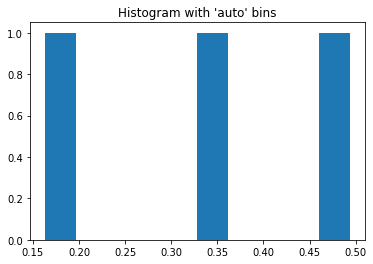

Train images


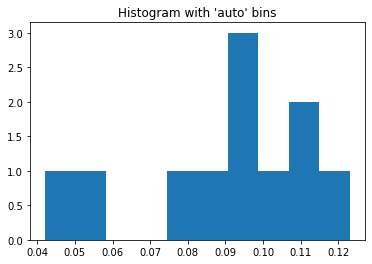

Train images


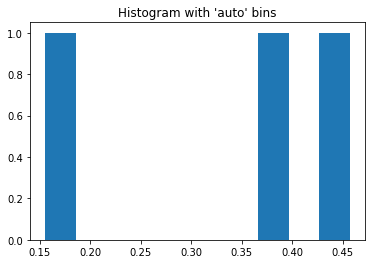

Train images


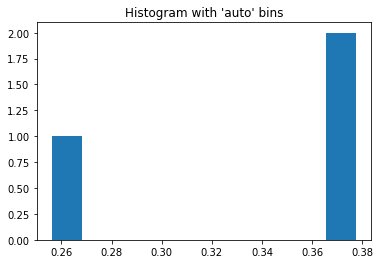

Train images


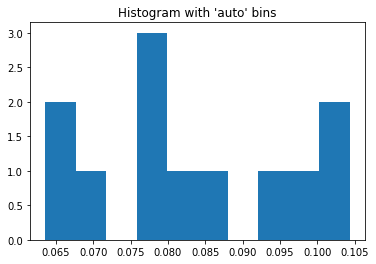

Train images


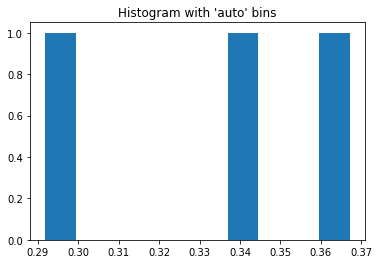

Train images


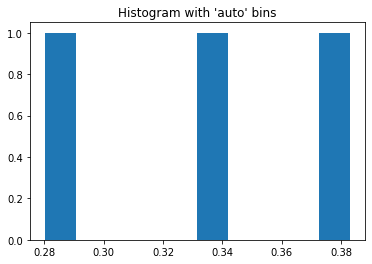

Train images


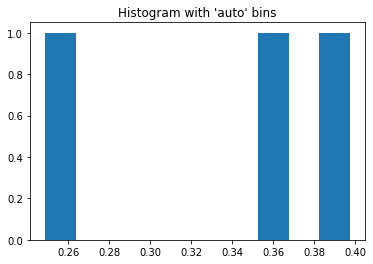

Train images


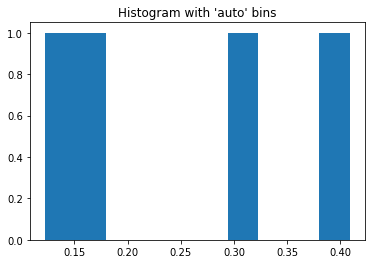

Train images


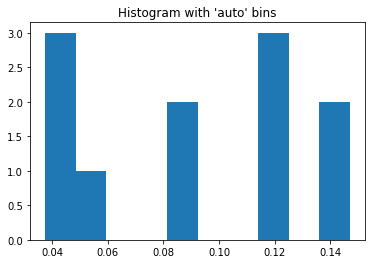

Train images


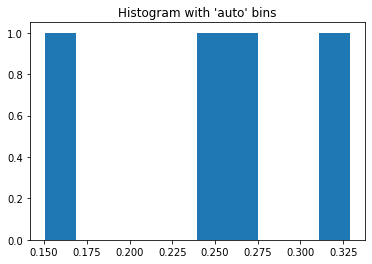

Train images


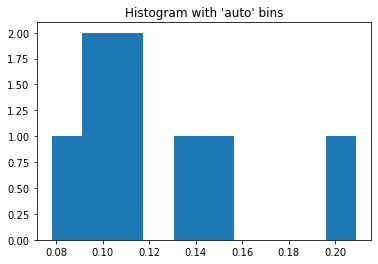

Train images


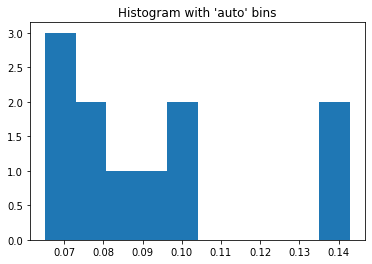

Train images


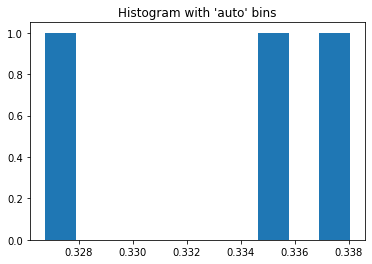

Train images


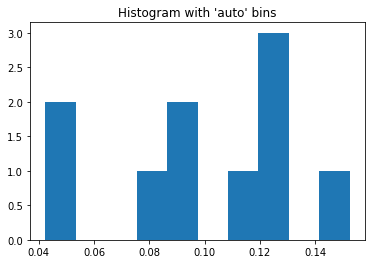

Train images


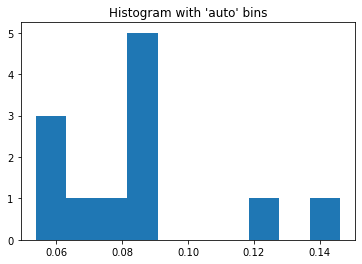

Train images


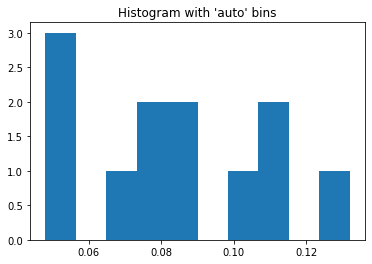

Train images


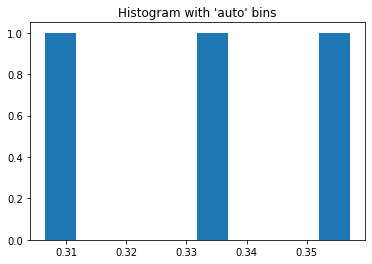

Train images


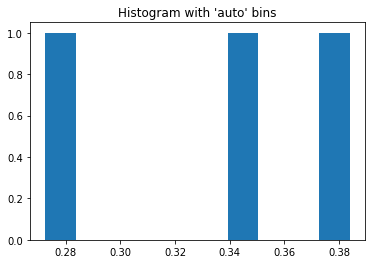

Train images


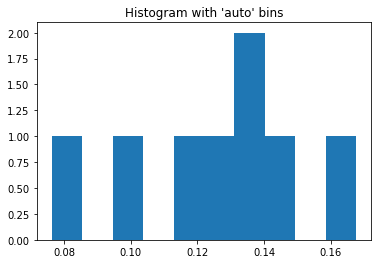

Train images


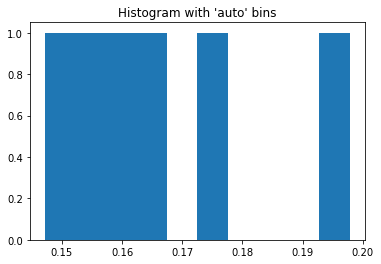

Train images


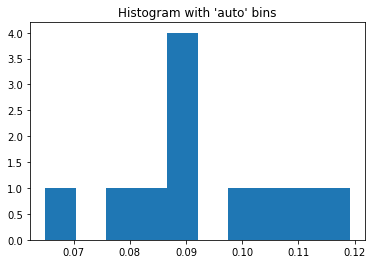

Train images


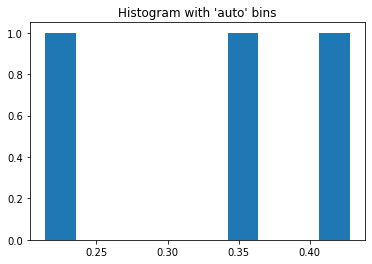

Train images


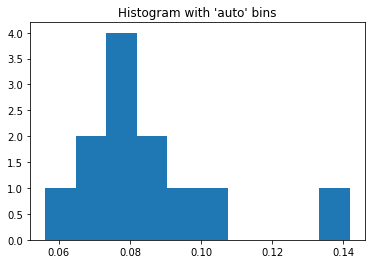

Train images


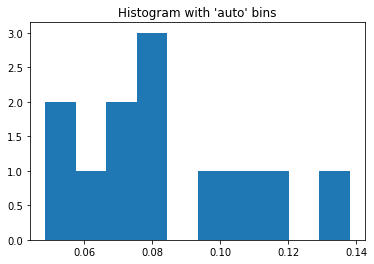

Train images


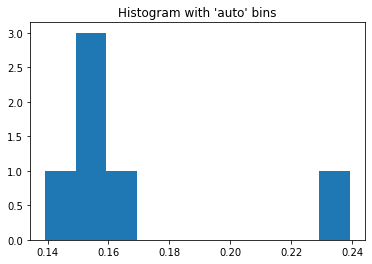

Train images


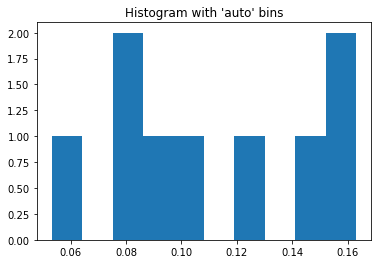

Train images


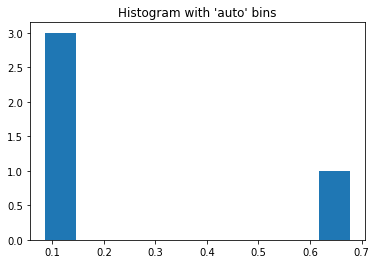

Train images


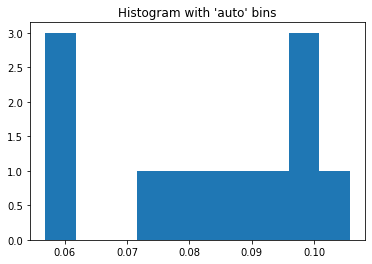

Train images


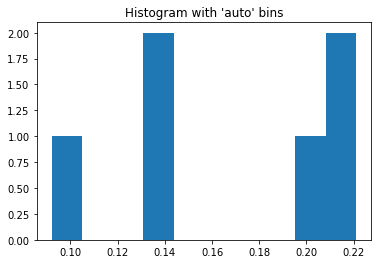

Train images


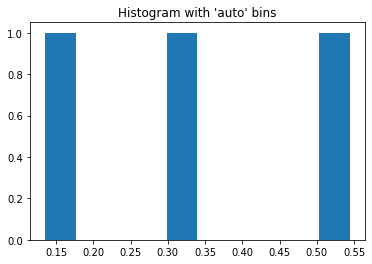

Train images


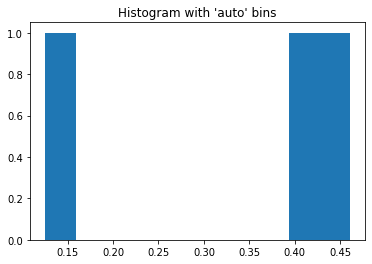

Train images


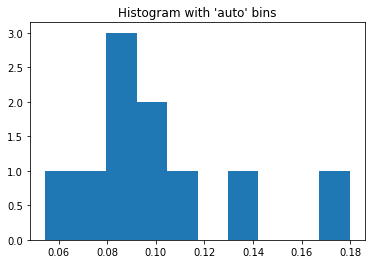

Train images


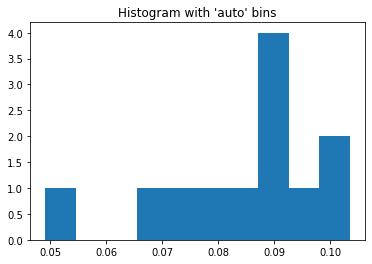

Train images


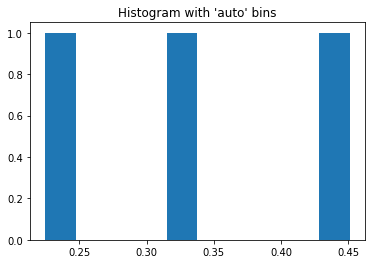

Train images


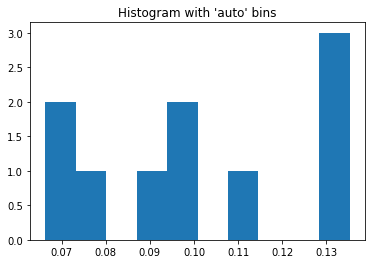

Train images


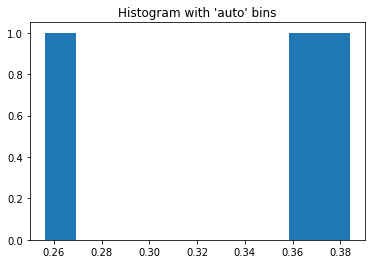

Train images


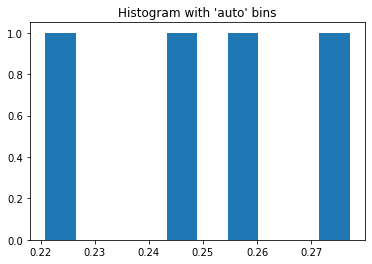

Train images


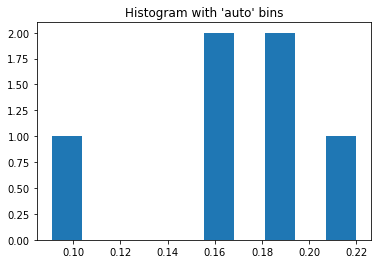

Train images


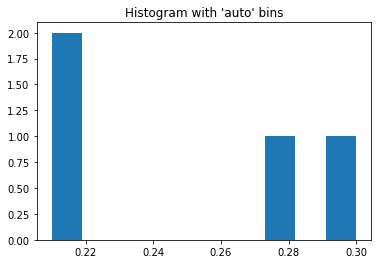

Train images


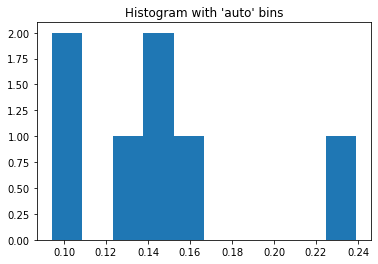

Train images


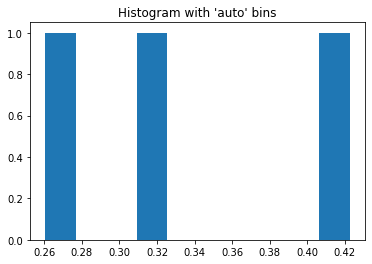

Train images


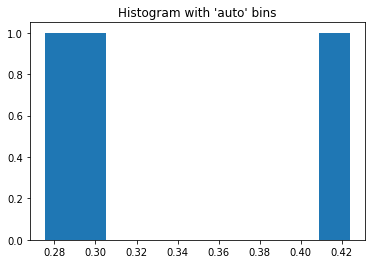

Train images


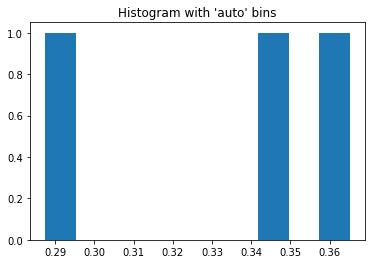

Train images


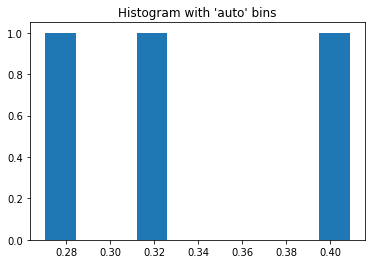

Train images


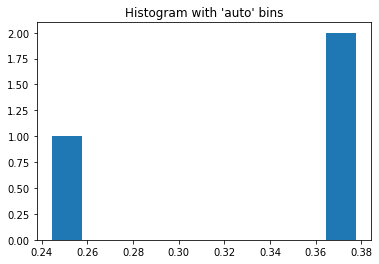

Train images


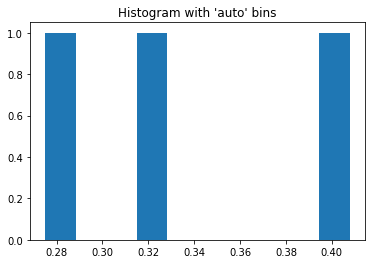

Train images


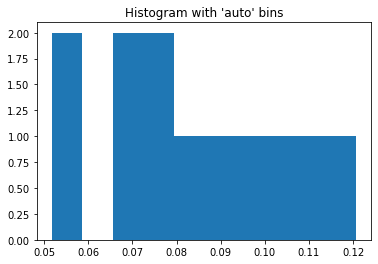

In [108]:
print(test_preprocessed_images)
'''
normalized_testing = []

for index, hist_test in enumerate(test_preprocessed_images):
  print("TESTING HISTOGRAMS")

  w = np.ones_like(hist_test)/float(len(hist_test))
  #hist_norm_test = hist_test/sum(hist_test)
  x = plt.hist(hist_test, weights=w)

  normalized_testing.append(x)

  t = "Histogram For Testing Image", index+1
  plt.title(t)
  #plt.show()

  print(x)

print(len(normalized_testing))

normalized_training = []
'''
'''
for index, hist_train in enumerate(training_preprocessed_images):
#Normalize the histogram
  print("TRAINING HISTOGRAMS")

  w = np.ones_like(hist_train)/float(len(hist_train))

  x = plt.hist(hist_train, weights=w)

  normalized_training.append(x)

  t = "Histogram For Training Image", index+1
  plt.title(t)
  #plt.show()

  print(x)'''

normalized_testing = []
for hist_test in test_preprocessed_images:
#Normalize the histogram
  print("Train images")
  #x = np.sum(hist_test)
  hist_norm_test = hist_test/np.sum(hist_test)
  normalized_testing.append(hist_norm_test)
  plt.hist(hist_norm_test)
  plt.title("Histogram with 'auto' bins")
  plt.show()

normalized_training = []
for hist_train in training_preprocessed_images:
#Normalize the histogram
  print("Train images")
  hist_norm_train = hist_train/np.sum(hist_train)
  normalized_training.append(hist_norm_train)
  plt.hist(hist_norm_train)
  plt.title("Histogram with 'auto' bins")
  plt.show()



In [173]:
'''
# Distanecs for each cluster
for s in range(len(set_of_dictionaries)):
  print("Image ", s)
  for c in range(len(set_of_dictionaries[s])):
    print("Cluster ", c)
    #km = KMeans[]
    for d in set_of_dictionaries[c][s]:
      # Find distances
      
      pass#print(d)
'''
for i, s in enumerate(final_dictionary):
  print("IMAGE ", i)
  for z, d in enumerate(s):
    print("CLUSTER ", z)
    for x, c in enumerate(d):
      print("DISTANCE ", x, " = ", c)

Streaming output truncated to the last 5000 lines.
  43.   0.   0.   0.   0.  25. 110.  28.   0.   0.   0.   0.   0.   2.
   1.   0.   0.   0.   7.   5.   0.   0.  30.   3.   3.   9.   4.   1.
  58. 139. 139.   7.   0.   0.   0.   0.  21. 139. 111.  17.   0.   0.
   0.   0.   0.  14.   5.   2.   0.   1.   7.   3.   0.   0.   0.   0.
   0.   0.   0.   0. 136. 139.  10.   0.   0.   0.   0.   0.  54. 120.
  30.   2.   0.   0.   0.   0.   4.  25.   6.   1.   0.  10.   6.   0.
   0.   1.]
DISTANCE  60  =  [ 52.  71.  58.  24.   0.   0.   1.  16.  63. 128.  34.  11.   9.   5.
   2.   3.  26.  28.  17.  26.  21.  27.  42.  18.  26.  22.   6.  25.
  16.   8.  11.  14.  32.  50.  61.  70.  10.   2.  10.  27. 128. 128.
  25.   3.   1.   1.   4.  51.  83.  27.  55.  30.   1.   7.  26.   8.
   1.   1.  44.  53.  25.   1.   6.   4.  19.   3.   2.   2.   2.   2.
 108. 128. 128.  33.  15.   5.   0.   3.  48.  94.  27.  26. 107.  59.
   2.   3.  15.   6.   0.   6. 111.  49.  12.  13.  10.   2.   0.   

## Step 4 ##


In [172]:
#data = []
#labels = [] # 0 = cars, 1 = airplanes
'''
# Reimport images
cars = [cv2.imread(file) for file in glob.glob("Training/Cars/*.jpg")]
# Convert images to greyscale
for i, img in enumerate(cars):
  cars[i] = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
for i, img in enumerate(cars):
  data.append(img)
  labels.append(0)

airplanes = [cv2.imread(file) for file in glob.glob("Training/Airplanes/*.jpg")]
# Convert images to greyscale
for i, img in enumerate(airplanes):
  airplanes[i] = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
for i, img in enumerate(airplanes):
  data.append(img)
  labels.append(1)
'''


data = []

for i in normalized_training:
  data.append(i)
  #labels.append(0)

for i in normalized_testing:
  data.append(i)
  #labels.append(1)

#cv2_imshow(test_images[11])
#print(labels[47])


from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)

print(X_test)
print(X_train)



'''
# Calculates the distances between two normalized histograms
def get_euclidian_distances(nhist1, nhist2):
  #return np.linalg.norm(np.subtract(nhist1, nhist2))

  c = ()
  for i in nhist1:
    if i not in nhist2:
      c = c + (i, )

  return c'''


#print(normalized_training[0])
#print(normalized_testing[0])
'''
min_distances = []

for n in normalized_training:

  min_dist = 10000

  for i, t in enumerate(normalized_testing):
    x = get_euclidian_distances(n, t)
    if x < min_dist:
      min_dist =  x

  
  min_distances.Append(min_dist)

print(len(min_distances))
print(min_distances)
'''
def L2_NN(trainx, trainy, testx):
  testy_L2 = []
  for i in range(len(testx)):
    #calculae the L2 distance
    

    for j in range(len(trainx)):
      for z in range(len(trainx[j])):
        distance = np.sum(np.square(testx[i]- trainx[j][z]))
        print("Distance", distance)

    test_predicted = trainy[np.argmin(distance)]
    testy_L2.append(test_predicted)
  
  return np.asarray(testy_L2)



#prediction

print("# PREDICTION #")

testy_L2 = L2_NN(X_train, y_train,X_test)

print(testy_L2)





[array([0.21      , 0.27333333, 0.21666667, 0.3       ]), array([0.07888041, 0.1043257 , 0.06870229, 0.09414758, 0.08651399,
       0.09669211, 0.07888041, 0.08142494, 0.06615776, 0.07888041,
       0.06361323, 0.10178117]), array([0.21994135, 0.09090909, 0.19061584, 0.16129032, 0.18181818,
       0.15542522]), array([0.35406091, 0.39720812, 0.24873096]), array([0.35967742, 0.38387097, 0.25645161]), array([0.09841828, 0.08260105, 0.09841828, 0.09314587, 0.1142355 ,
       0.08084359, 0.04217926, 0.05272408, 0.11072056, 0.12302285,
       0.10369069]), array([0.06902985, 0.1119403 , 0.09514925, 0.1380597 , 0.06529851,
       0.07835821, 0.05410448, 0.10634328, 0.04850746, 0.06902985,
       0.08395522, 0.08022388]), array([0.41409692, 0.12555066, 0.46035242]), array([0.072, 0.084, 0.108, 0.132, 0.048, 0.056, 0.1  , 0.076, 0.084,
       0.076, 0.108, 0.056]), array([0.25702811, 0.27710843, 0.22088353, 0.24497992])]
[array([0.1978022 , 0.15824176, 0.15604396, 0.16703297, 0.14725275,
     

## Part 5 - Calculate the error rate ##



In [145]:
def error_rate(testy, testy_fit):
  return float(np.sum(testy!=testy_fit))/len(testy)

print("Error rate:", error_rate(y_test, testy_L2))

acc = (1 - error_rate(y_test, testy_L2)) * 100
print("Accuracy Rate: ", acc, "%")

Error rate: 0.8
Accuracy Rate:  19.999999999999996 %


## Part 5 - Confusion Matrix ##

In [143]:
def confusionMatrix(testy, testy_fit):
  matrix_dimension = len(np.unique(testy))
  confusionMatrix = np.zeros((matrix_dimension, matrix_dimension))
  for i in range(len(testy)):
    confusionMatrix[int(testy[i])][int(testy_fit[i])] +=1

  return confusionMatrix


confusionMatrix(y_test, testy_L2)

array([[2., 0., 0.],
       [4., 0., 0.],
       [4., 0., 0.]])

## Part 6 - Histogram intersection between 2 histograms## 

In [171]:
def hist_inter(h1, h2):
  sm = 0
  for i in range(len(h2)):
    sm += min(h1[i], h2[i])
  return sm



def L2_NN(trainx, trainy, testx):
  testy_L2 = []
  for i in range(len(testx)):


    hist_intersection = hist_inter(testx[i], trainx[i])
    print("Intersection", hist_intersection)

    test_predicted = trainy[np.argmin(hist_intersection)]
    testy_L2.append(test_predicted)
  
  return np.asarray(testy_L2)



print("# PREDICTION #")

testy_L2 = L2_NN(X_train, y_train,X_test)

print(testy_L2)




# PREDICTION #
38
10
36
12


IndexError: ignored

# Step 7 - HOW TO: #

Go to "Step 2/32." and change the "MAX_LIMIT" constant to 20. Then, proceed with running the other steps as mentioned in the assignment PDF file. Most of step 7 is done in the report. :)